In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pybullet as pb
import pybullet_data
import time

In [2]:
def read_parameters(dbg_params):
    '''Reads values from debug parameters
    
    Parameters
    ----------
    dbg_params : dict
        Dictionary where the keys are names (str) of parameters and the values are
        the itemUniqueId (int) for the corresponing debug item in pybullet
    
    Returns
    -------
    dict 
        Dictionary that maps parameter names (str) to parameter values (float)
    '''
    values = dict()
    for name, param in dbg_params.items():
        values[name] = pb.readUserDebugParameter(param)

    return values

In [3]:

def interactive_camera_placement(pos_scale=1., max_dist=10., show_plot=True, verbose=True):
    np.set_printoptions(suppress=True, precision=4)

    dbg = dict()
    # for view matrix
    dbg['target_x'] = pb.addUserDebugParameter('target_x', -pos_scale, pos_scale, 0)
    dbg['target_y'] = pb.addUserDebugParameter('target_y', -pos_scale, pos_scale, 0)
    dbg['target_z'] = pb.addUserDebugParameter('target_z', -pos_scale, pos_scale, 0)
    dbg['distance'] = pb.addUserDebugParameter('distance', 0, max_dist, max_dist/2)
    dbg['yaw'] =  pb.addUserDebugParameter('yaw', -180, 180, 0)
    dbg['pitch'] =  pb.addUserDebugParameter('pitch', -180, 180, -40)
    dbg['roll'] =  pb.addUserDebugParameter('roll', -180, 180, 0)
    dbg['upAxisIndex'] =  pb.addUserDebugParameter('toggle upAxisIndex', 1, 0, 1)

    # for projection matrix
    dbg['width'] = pb.addUserDebugParameter('width', 100, 1000, 320)
    dbg['height'] = pb.addUserDebugParameter('height', 100, 1000, 240)
    dbg['fov'] = pb.addUserDebugParameter('fov', 1, 180, 50)
    dbg['near_val'] = pb.addUserDebugParameter('near_val', 1e-6, 1, 0.1)
    dbg['far_val'] = pb.addUserDebugParameter('far_val', 1, 100, 10)

    # visual aids for target and camera pose
    target_vis_id = pb.createVisualShape(pb.GEOM_SPHERE,radius=0.01, rgbaColor=[1,0,0,0.7])
    target_body = pb.createMultiBody(0, -1, target_vis_id)

    camera_vis_id = pb.createVisualShape(pb.GEOM_BOX,halfExtents=[0.02, 0.05, 0.02], rgbaColor=[1,0,0,0.7])
    camera_body = pb.createMultiBody(0, -1, camera_vis_id)

    # pyplot window to show feed
    if show_plot:
        plt.figure()
        plt_im = plt.imshow(np.zeros((240,320,4)))
        plt.axis('off')
        plt.tight_layout(pad=0)

    dbg['print'] =  pb.addUserDebugParameter('print params', 1, 0, 1)
    old_print_val = 1
    while 1:
        values = read_parameters(dbg)

        target_pos = np.array([values[f'target_{c}'] for c in 'xyz'])
        upAxisIndex = (int(values['upAxisIndex']) % 2 ) + 1
        view_mtx = pb.computeViewMatrixFromYawPitchRoll(target_pos, values['distance'],values['yaw'],values['pitch'],values['roll'],upAxisIndex)

        width = int(values['width'])
        height = int(values['height'])
        aspect = width/height
        proj_mtx = pb.computeProjectionMatrixFOV(values['fov'],aspect,values['near_val'], values['far_val'])

        #update visual aids for camera, target pos
        pb.resetBasePositionAndOrientation(target_body, target_pos, [0,0,0,1])

        view_mtx = np.array(view_mtx).reshape((4,4),order='F')
        cam_pos = np.dot(view_mtx[:3,:3].T, -view_mtx[:3,3])
        cam_euler = np.radians([values['pitch'],values['roll'],values['yaw']])
        cam_quat = pb.getQuaternionFromEuler(cam_euler)
        pb.resetBasePositionAndOrientation(camera_body, cam_pos, cam_quat)

        view_mtx = view_mtx.reshape(-1, order='F')
        img = pb.getCameraImage(width, height, view_mtx, proj_mtx)[2]
       

        if old_print_val != values['print']:
            old_print_val = values['print']
            print("\n========================================")
            print(f"VIEW MATRIX : \n{np.array_str(view_mtx)}")
            print(f"PROJECTION MATRIX : \n{np.array(proj_mtx)}")
            if verbose:
                print(f"target position : {np.array_str(target_pos)}")
                print(f"distance : {dbg['distance']:.2f}")
                print(f"yaw : {dbg['yaw']:.2f}")
                print(f"pitch : {dbg['pitch']:.2f}")
                print(f"roll : {dbg['roll']:.2f}")
                print(f"upAxisIndex : {upAxisIndex:d}")
                print(f"width : {width:d}")
                print(f"height : {height:d}")
                print(f"fov : {dbg['fov']:.1f}")
                print(f"aspect : {aspect:.2f}")
                print(f"nearVal : {dbg['near_val']:.2f}")
                print(f"farVal : {dbg['far_val']:.2f}")
            print("========================================\n")
    print(proj_mtx)

In [4]:
def read_parameters(dbg_params):
    '''Reads values from debug parameters
    
    Parameters
    ----------
    dbg_params : dict
        Dictionary where the keys are names (str) of parameters and the values are
        the itemUniqueId (int) for the corresponing debug item in pybullet
    
    Returns
    -------
    dict 
        Dictionary that maps parameter names (str) to parameter values (float)
    '''
    values = dict()
    for name, param in dbg_params.items():
        values[name] = pb.readUserDebugParameter(param)

    return values

In [5]:
def initialize_simulator():
    '''Creates a pybullet simulator in GUI mode and adds some objects so the
    camera has something to look at
    '''
    pb.connect(pb.GUI)
    pb.setAdditionalSearchPath(pybullet_data.getDataPath())
    pb.loadURDF('plane.urdf')

    # add a duck
    pb.loadURDF('r2d2.urdf', [0,0,1], globalScaling = 1)
    pb.setGravity(0,0,-10)
    
   


VIEW MATRIX : 
[ 1.      0.     -0.      0.     -0.      0.6428 -0.766   0.      0.
  0.766   0.6428  0.     -0.     -0.     -5.      1.    ]
PROJECTION MATRIX : 
[ 1.6084  0.      0.      0.      0.      2.1445  0.      0.      0.
  0.     -1.0202 -1.      0.      0.     -0.202   0.    ]
target position : [0. 0. 0.]
distance : 3.00
yaw : 4.00
pitch : 5.00
roll : 6.00
upAxisIndex : 2
width : 320
height : 240
fov : 10.0
aspect : 1.33
nearVal : 11.00
farVal : 12.00



error: Not connected to physics server.

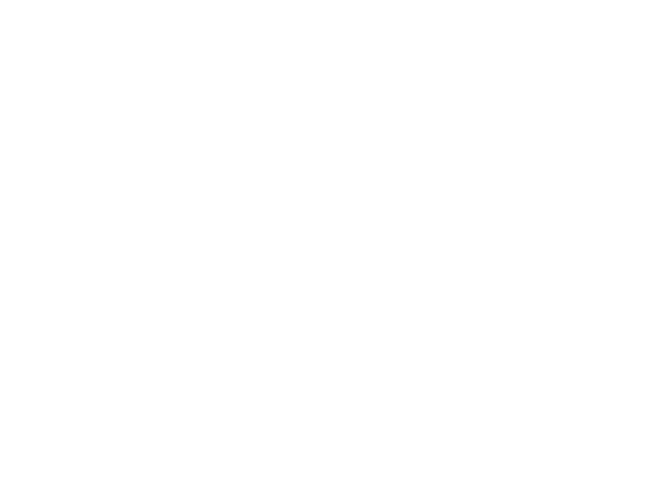

In [6]:
if __name__ == "__main__":
    
    # Substitute this for the initialization of your simulator
    initialize_simulator()
    interactive_camera_placement()